In [30]:
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model, image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import pathlib
import time
import cv2
import os
import random
import re

### Paths

In [32]:
images_path = '../../../Dataset/teamphotos_ready/'

### Hyperparameters

In [33]:
images_num=20

train_size=0.5

image_shape=(224, 224, 3)

batch_size=10
lr=0.00001

## Creating pairs

In [34]:
def slicer(array, index_from, index_to):
    array_copy = array.copy()
    del array_copy[index_from:index_to]
    return array_copy

In [35]:
def get_balanced_pair(path):
    containing_id_list = []
    photos = os.listdir(path)
    photos.sort(key=lambda f: int(re.sub('\D', '', f)))
    
    photo_sample = random.sample(photos, 1)
    photo_sample = photo_sample[0]
    photo_index = photos.index(photo_sample)
    if photo_index % 2 == 1:
        containing_id_list.append(photos[photo_index])
        containing_id_list.append(photos[photo_index - 1])
        negative = random.sample(slicer(photos, photo_index - 1, photo_index + 1), 1)
        negative = negative[0]
        return [[containing_id_list[0], containing_id_list[1], 1], [containing_id_list[0], negative, 0]]
    else:
        containing_id_list.append(photos[photo_index])
        containing_id_list.append(photos[photo_index + 1])
        negative = random.sample(slicer(photos, photo_index, photo_index + 1), 1)
        negative = negative[0]
        return [[containing_id_list[0], containing_id_list[1], 1], [containing_id_list[0], negative, 0]]

In [36]:
balanced_pairs = []
random.seed(64)

for i in range(images_num):
    pair = get_balanced_pair(images_path)
    balanced_pairs.append(pair[0])
    balanced_pairs.append(pair[1])
    
df_train = pd.DataFrame(balanced_pairs, columns =['left', 'right', 'label'])
df_train['left'] = images_path  + df_train['left']
df_train['right'] = images_path + df_train['right']

In [37]:
df_train

,left,right,label
0,../../../Dataset/teamphotos_ready/train_16.jpg,../../../Dataset/teamphotos_ready/train_15.jpg,1
1,../../../Dataset/teamphotos_ready/train_16.jpg,../../../Dataset/teamphotos_ready/train_4.jpg,0
2,../../../Dataset/teamphotos_ready/train_23.jpg,../../../Dataset/teamphotos_ready/train_24.jpg,1
3,../../../Dataset/teamphotos_ready/train_23.jpg,../../../Dataset/teamphotos_ready/train_21.jpg,0
4,../../../Dataset/teamphotos_ready/train_13.jpg,../../../Dataset/teamphotos_ready/train_14.jpg,1
5,../../../Dataset/teamphotos_ready/train_13.jpg,../../../Dataset/teamphotos_ready/train_20.jpg,0
6,../../../Dataset/teamphotos_ready/train_24.jpg,../../../Dataset/teamphotos_ready/train_23.jpg,1
7,../../../Dataset/teamphotos_ready/train_24.jpg,../../../Dataset/teamphotos_ready/train_1.jpg,0
8,../../../Dataset/teamphotos_ready/train_7.jpg,../../../Dataset/teamphotos_ready/train_8.jpg,1
9,../../../Dataset/teamphotos_ready/train_7.jpg,../../../Dataset/teamphotos_ready/train_10.jpg,0


In [38]:
balanced_pairs_test = []
random.seed(128)

for i in range(images_num):
    pair = get_balanced_pair(images_path)
    balanced_pairs_test.append(pair[0])
    balanced_pairs_test.append(pair[1])
    
df_test = pd.DataFrame(balanced_pairs_test, columns =['left', 'right', 'label'])
df_test['left'] = images_path + df_test['left']
df_test['right'] = images_path + df_test['right']

In [39]:
df_test

,left,right,label
0,../../../Dataset/teamphotos_ready/train_8.jpg,../../../Dataset/teamphotos_ready/train_7.jpg,1
1,../../../Dataset/teamphotos_ready/train_8.jpg,../../../Dataset/teamphotos_ready/train_15.jpg,0
2,../../../Dataset/teamphotos_ready/train_17.jpg,../../../Dataset/teamphotos_ready/train_18.jpg,1
3,../../../Dataset/teamphotos_ready/train_17.jpg,../../../Dataset/teamphotos_ready/train_12.jpg,0
4,../../../Dataset/teamphotos_ready/train_5.jpg,../../../Dataset/teamphotos_ready/train_6.jpg,1
5,../../../Dataset/teamphotos_ready/train_5.jpg,../../../Dataset/teamphotos_ready/train_17.jpg,0
6,../../../Dataset/teamphotos_ready/train_1.jpg,../../../Dataset/teamphotos_ready/train_2.jpg,1
7,../../../Dataset/teamphotos_ready/train_1.jpg,../../../Dataset/teamphotos_ready/train_6.jpg,0
8,../../../Dataset/teamphotos_ready/train_11.jpg,../../../Dataset/teamphotos_ready/train_12.jpg,1
9,../../../Dataset/teamphotos_ready/train_11.jpg,../../../Dataset/teamphotos_ready/train_24.jpg,0


### Create test train val split

In [40]:
#X_train, X_rem, y_train, y_rem = train_test_split(df.iloc[:,:-1], df.iloc[:,-1:], train_size=train_size, random_state = 101, shuffle=True)

In [41]:
X_train = df_train[["left", "right"]]
Y_train_label = df_train[["label"]]

In [42]:
X_test = df_test[["left", "right"]]
Y_test_label = df_test[["label"]]

In [43]:
print('=====Training=====')
print(X_train.shape)
print(Y_train_label.shape)

print('=====Testing=====')
print(X_test.shape)
print(Y_test_label.shape)

=====Training=====
(40, 2)
(40, 1)
=====Testing=====
(40, 2)
(40, 1)


### Loading pairs into TF Dataset

In [44]:
def preprocessing(left, right):
    return convert_to_img(left), convert_to_img(right)


def convert_to_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.image.per_image_standardization(img)
    #img = tf.expand_dims(img, axis=0)
    img = tf.reshape(img,(224,224,3))
    return img

def label_preprocessing(label):
    return tf.cast(label, tf.float32)

In [45]:
def create_dataset(features, labels):
    feature_ds = tf.data.Dataset.from_tensor_slices((features['left'].values, features['right'].values))
    labels_ds = tf.data.Dataset.from_tensor_slices(labels.values)
    
    feature_ds = feature_ds.map(preprocessing)
    labels_ds = labels_ds.map(label_preprocessing)
    
    dataset = tf.data.Dataset.zip((feature_ds, labels_ds))
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

def create_dataset_no_labels(features):
    feature_ds = tf.data.Dataset.from_tensor_slices((features['left'].values, features['right'].values))
    feature_ds = feature_ds.map(preprocessing)
    
    feature_ds = feature_ds.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    feature_ds = feature_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return feature_ds

def create_singular_dataset(feature):
    dataset = tf.data.Dataset.from_tensor_slices(feature.values)
    dataset = dataset.map(convert_to_img)
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [46]:
train_ds = create_dataset(X_train, Y_train_label)
val_ds = create_dataset(X_test, Y_test_label)

## NN model

In [47]:
left_input = layers.Input(shape=(224, 224, 3), name='left_input')
right_input = layers.Input(shape=(224, 224, 3), name='right_input')

### ResNet50 model

In [48]:
trainable_layers=33 #whole conv_5 block

def resnet_network():
    input = layers.Input(shape=(224, 224, 3))
    
    resnet=ResNet50(
        input_tensor=input,
        include_top=False,
        input_shape=image_shape,
        pooling='avg',
        weights='imagenet',
        classes=2)

    # whole conv5 block
    for layer in resnet.layers[0:-trainable_layers]:
        layer.trainable = False

    return Model(input, outputs=resnet.output, name='resnet50')

In [49]:
def conv_network(): 
    input = layers.Input(shape=image_shape, name='input_image')
    
    # First block
    c1 = layers.Conv2D(64, (10,10), activation='relu')(input)
    m1 = layers.MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = layers.Conv2D(128, (7,7), activation='relu')(m1)
    m2 = layers.MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = layers.Conv2D(128, (4,4), activation='relu')(m2)
    m3 = layers.MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = layers.Conv2D(256, (4,4), activation='relu')(m3)
    f1 = layers.Flatten()(c4)
    d1 = layers.Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=input, outputs=d1, name='conv_net')

In [50]:
def base_network():
    input = layers.Input(shape=(224, 224, 3))
    x = layers.Flatten()(input)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    return Model(inputs=input, outputs=x, name='base_network')

In [51]:
base_model = conv_network()

model_left = base_model(left_input)
model_right = base_model(right_input)

### Merging resnet branches layers

In [52]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(tf.subtract(x, y)), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

In [53]:
#merged = layers.subtract([model_left.output, model_right.output])
model = layers.Lambda(euclidean_distance, name="merge")([model_left, model_right])

#model = layers.Flatten()(model)

#model = layers.Dense(256, activation='relu')(model)
#model = layers.Dropout(.2)(model)

#model = layers.Dense(32, activation='relu')(model)

model = layers.Dense(1, activation='sigmoid')(model)

model = Model(inputs = [left_input, right_input], outputs = model, name='conv_model')

In [54]:
# margin is a parametr settable by developer
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)    
    return contrastive_loss

In [55]:
model.compile(optimizer=Adam(learning_rate=lr), loss=contrastive_loss_with_margin(margin=1.0))

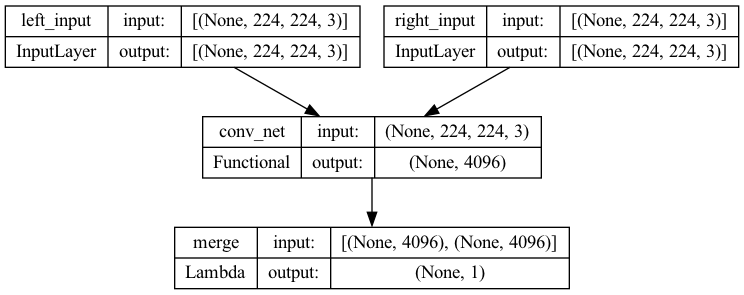

In [56]:
plot_model(model, show_shapes=True)
#model.summary()

In [57]:
#checkpoint_dir = 'checkpoints/own-photos-conv_net-20221128-202929'
#latest_ckpt = tf.train.latest_checkpoint(checkpoint_dir)

#model.load_weights(latest_ckpt)

In [ ]:
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


2022-11-28 22:41:07.461540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.2901

2022-11-28 22:41:33.155197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 27s 7s/step - loss: 0.2901 - val_loss: 0.2405
Epoch 2/10
4/4 [==============================] - 26s 7s/step - loss: 0.2102 - val_loss: 0.2110
Epoch 3/10
4/4 [==============================] - 26s 7s/step - loss: 0.1656 - val_loss: 0.1931
Epoch 4/10
4/4 [==============================] - 27s 7s/step - loss: 0.1290 - val_loss: 0.1745
Epoch 5/10
4/4 [==============================] - 27s 7s/step - loss: 0.0979 - val_loss: 0.1610
Epoch 6/10
4/4 [==============================] - 27s 7s/step - loss: 0.0742 - val_loss: 0.1503
Epoch 7/10
4/4 [==============================] - 27s 7s/step - loss: 0.0545 - val_loss: 0.1378
Epoch 8/10
4/4 [==============================] - 27s 7s/step - loss: 0.0383 - val_loss: 0.1251
Epoch 9/10
3/4 [=====================>........] - ETA: 6s - loss: 0.0262 

In [ ]:
#checkpoints_path = 'checkpoints'
#model_version = f'{model.name}-own_photos-{time.strftime("%Y%m%d-%H%M%S")}'

#!cd {checkpoint_path} && mkdir {model_version}

#model_path = f'{checkpoints_path}/{model_version}'
#model.save_weights(model_path)

### Performance metrics

In [ ]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()

plt.show()

### Predictions

In [ ]:
test_ds_left = create_singular_dataset(X_test['left'])
test_ds_right = create_singular_dataset(X_test['right'])
test_labels = Y_test_label['label']

test_ds_full = create_dataset_no_labels(X_test)

In [ ]:
left_image_feature_vectors = base_model.predict(test_ds_left)
right_image_feature_vectors = base_model.predict(test_ds_right)

In [ ]:
positive_left_image_feature_vectors = left_image_feature_vectors[0::2]
negative_left_image_feature_vectors = left_image_feature_vectors[1::2]

positive_right_image_feature_vectors = right_image_feature_vectors[0::2]
negative_right_image_feature_vectors = right_image_feature_vectors[1::2]

### Positive distances

In [ ]:
positive_distances = euclidean_distance((positive_left_image_feature_vectors, positive_right_image_feature_vectors)).numpy().flatten()
positive_mean = pd.Series(positive_distances).mean()
pd.Series(positive_distances).describe()

### Negative distances

In [ ]:
negative_distances = euclidean_distance((negative_left_image_feature_vectors, negative_right_image_feature_vectors)).numpy().flatten()
negative_mean = pd.Series(negative_distances).mean()
pd.Series(negative_distances).describe()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1, 1])
ax.boxplot([positive_distances, negative_distances])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [ ]:
def compute_accuracy(y_true, y_pred, cutoff):
    pred = y_pred.flatten() < cutoff
    return np.mean(pred == y_true), pred

In [ ]:
y_pred_test = euclidean_distance((left_image_feature_vectors, right_image_feature_vectors)).numpy().flatten()
cutoff = (positive_mean + negative_mean)/2

test_accuracy, y_pred = compute_accuracy(test_labels, y_pred_test, cutoff)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

In [ ]:
confusion_matrix(Y_test_label, y_pred, labels = [1,0])

In [ ]:
def display_images(left, right, predictions, title, n):
    fig, axarr = plt.subplots(2,10, figsize=(17,3))
    plt.setp(axarr, xticks=[], yticks=[])
    
    for image, i in zip(left, range(len(left))):
        img = cv2.imread(image)
        axarr[0,i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axarr[0,i].grid(None)
        
    for image, i in zip(right, range(len(right))):
        img = cv2.imread(image)
        axarr[1,i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axarr[1,i].grid(None)
        axarr[1,i].set_xticks(predictions)

    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > cutoff: 
            t.set_color('red')

In [ ]:
y_pred_test = np.squeeze(y_pred_test)
indexes = np.random.choice(len(y_pred_test), size=10)
display_images(X_test["left"][indexes],
               X_test["right"][indexes],
               y_pred_test[indexes],
               'Clothes and their dissimilarity', 10)

In [ ]:
skuska = cv2.imread(X_test["left"][0])

In [ ]:
y_pred_test[0:10]

In [ ]:
indexes